<a href="https://colab.research.google.com/github/myounghunseo/PowerApps-Samples/blob/master/follow_kaggle01_modeling%5BLogistic_LGBM%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
# os.environ을 이용하여 Kaggle API Username, Key 세팅하기
os.environ['KAGGLE_USERNAME'] = 'myounghunseo'
os.environ['KAGGLE_KEY'] = '14a52cecb7b87da6c97d633d4815e71a'

In [3]:
!kaggle competitions download -c santander-customer-satisfaction
!unzip '*.zip'

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               

Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                

2 archives were successfully processed.


In [5]:
!ls

sample_data	       test.csv      train.csv
sample_submission.csv  test.csv.zip  train.csv.zip


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
import lightgbm as lgb
from lightgbm import plot_importance
import xgboost as xgb


from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [8]:
print('Train data shape :', train_df.shape)
print('test data shape:', test_df.shape)

Train data shape : (76020, 371)
test data shape: (75818, 370)


In [9]:
features = train_df.drop(['ID','TARGET'],axis=1)

## EDA


*   Target Percent
*   Check Multicolinearity
*   Check Outlier




In [10]:
pd.DataFrame(train_df['TARGET'].value_counts())

,TARGET
0,73012
1,3008


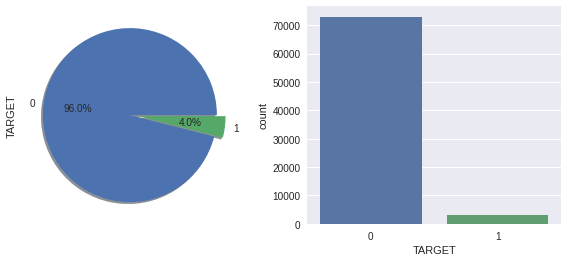

In [11]:
f, ax = plt.subplots(1,2,figsize=(10,4))
train_df['TARGET'].value_counts().plot.pie(
    explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True
)
sns.countplot('TARGET', data=train_df, ax=ax[1])
plt.show()

In [12]:
null_value = train_df.isnull().sum().sort_values(ascending=False)
null_percent = round(train_df.isnull().sum().sort_values(ascending=False)/len(train_df)*100,2)
pd.concat([null_value, null_percent], axis=1, keys=['Null values', 'Percent'])

,Null values,Percent
TARGET,0,0.0
num_op_var41_ult1,0,0.0
num_var26,0,0.0
num_var25_0,0,0.0
num_var25,0,0.0
...,...,...
imp_trasp_var33_out_hace3,0,0.0
imp_trasp_var33_out_ult1,0,0.0
imp_venta_var44_hace3,0,0.0
imp_venta_var44_ult1,0,0.0


In [13]:
features[features.columns[:8]].corr()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1
var3,1.000000,-0.004452,0.001868,0.005989,0.006817,0.001518,0.001690,0.000530
var15,-0.004452,1.000000,0.043722,0.094762,0.101177,0.042754,0.048512,0.008805
imp_ent_var16_ult1,0.001868,0.043722,1.000000,0.041221,0.034879,0.009896,0.009377,0.000592
imp_op_var39_comer_ult1,0.005989,0.094762,0.041221,1.000000,0.886476,0.342709,0.295295,0.032280
imp_op_var39_comer_ult3,0.006817,0.101177,0.034879,0.886476,1.000000,0.316671,0.355670,0.029094
imp_op_var40_comer_ult1,0.001518,0.042754,0.009896,0.342709,0.316671,1.000000,0.852206,0.061187
imp_op_var40_comer_ult3,0.001690,0.048512,0.009377,0.295295,0.355670,0.852206,1.000000,0.053579
imp_op_var40_efect_ult1,0.000530,0.008805,0.000592,0.032280,0.029094,0.061187,0.053579,1.000000


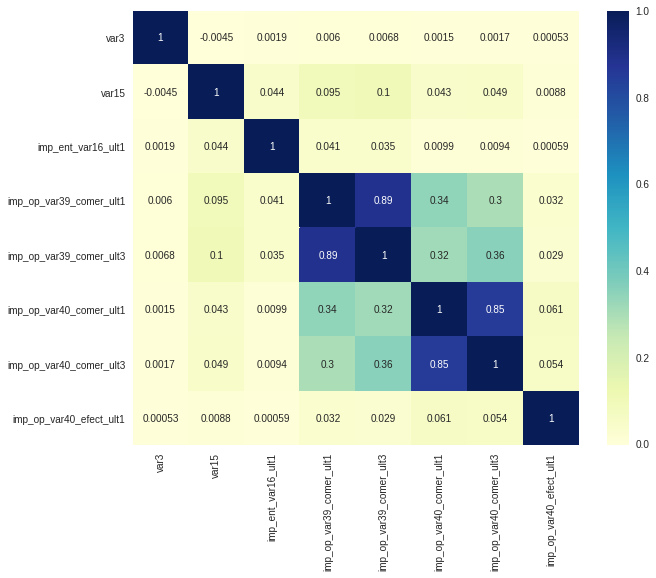

In [14]:
sns.heatmap(features[features.columns[:8]].corr(),annot=True,cmap='YlGnBu')
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

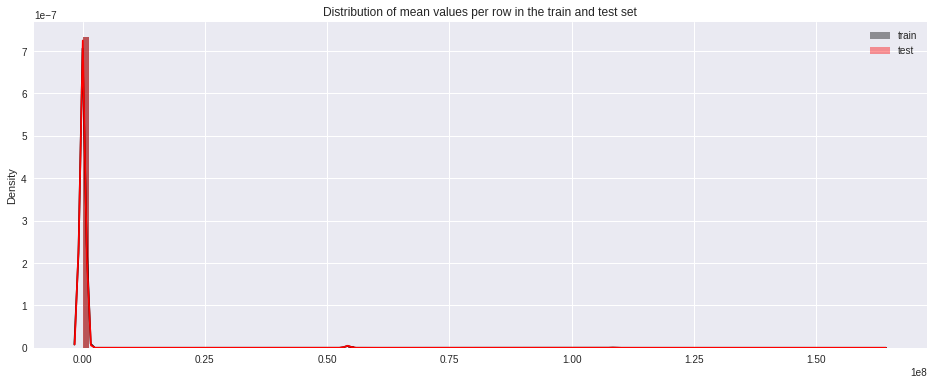

In [15]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features.columns].mean(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test_df[features.columns].mean(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

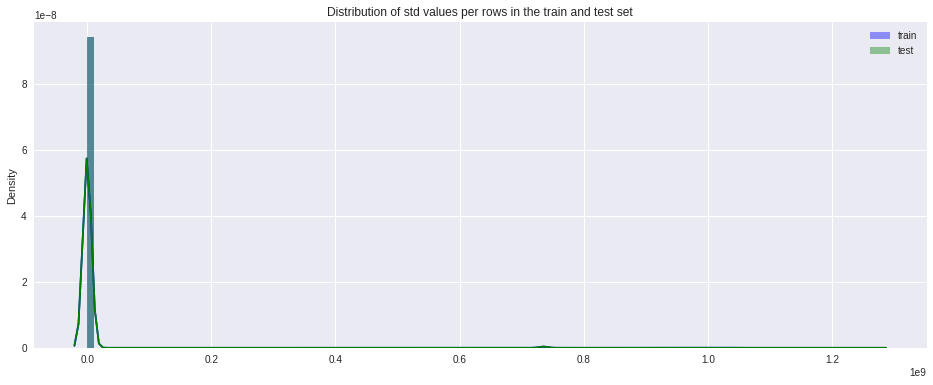

In [16]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per rows in the train and test set")
sns.distplot(train_df[features.columns].std(axis=1),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_df[features.columns].std(axis=1),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

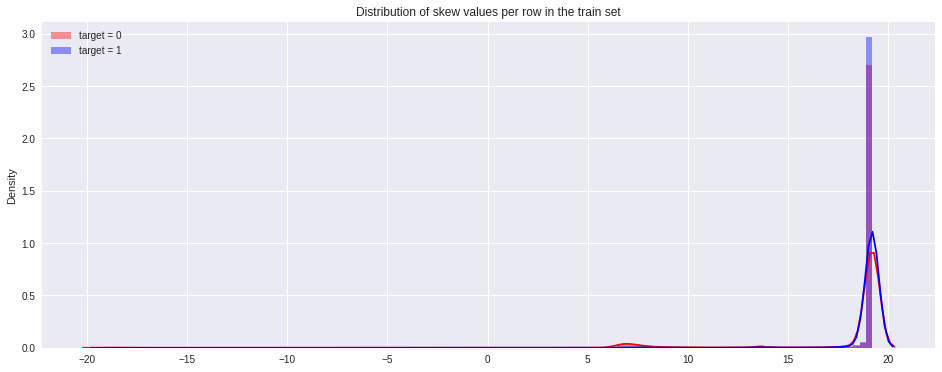

In [17]:
t0 = train_df[train_df['TARGET'] == 0]
t1 = train_df[train_df['TARGET'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features.columns].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features.columns].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

In [18]:
train_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.0,0.0,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.000026,0.050855,...,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.0,0.513023,0.344174,9.117181e+01,3.646318e+01,1.310316e+02,1.092169e+02,0.213071,0.001910,0.253907,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,512.154823,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,465.391149,0.106425,0.061221,0.0,0.0,0.200535,0.472425,0.010258,0.005129,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.100325,0.099486,0.005129,0.005129,0.219703,...,9614.906985,8189.948852,1733.838226,519.389157,2205.249804,1935.305713,3.777314e+04,9292.752726,4.620254e+04,3.550718e+04,26359.174223,7182

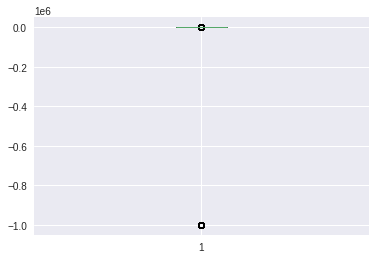

In [19]:
plt.boxplot(train_df['var3'])
plt.show()

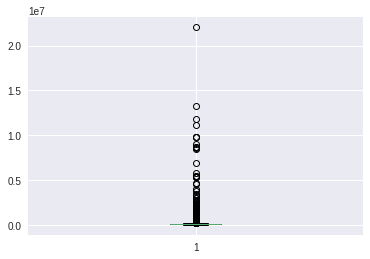

In [20]:
plt.boxplot(train_df['var38'])
plt.show()

## Preprocessing


*   Processing Outlier Values




In [20]:
train_df.describe()[3:]

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
min,1.00,-999999.0,5.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-922.38,-476.07,-287.67,0.00,-3401.34,-1844.52,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,-0.03,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,5.163750e+03,0.0
25%,38104.75,2.0,23.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,6.787061e+04,0.0
50%,76043.00,2.0,28.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.00,2.73,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.064092e+05,0.0
75%,113748.75,2.0,40.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,90.00,83.79,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.187563e+05,0.0
max,151838.00,238.0,105.0,210000.0,12888.03,21024.81,8237.82,11073.57,6600.0,6600.0,8237.82,12888.03,16566.81,45990.0,131100.0,47598.09,45990.0,131100.0,47598.09,105000.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,601428.60,544365.57,231351.99,77586.21,228031.80,177582.00,3000538.14,668335.32,3004185.6,2272859.43,450000.0,304838.7,450000.0,450000.0,840000.0,534000.0,1500000.0,1034482.74,7741.95,0.0,30000.0,18870.99,4210084.23,2368558.95,3998687.46,3525776.88,10430.01,145.2,13793.67,7331.34,50003.88,20385.72,138831.63,91778.73,438329.22,24650.01,681462.9,397884.3,2.203474e+07,1.0


In [21]:
train_df['var3'].replace(-999999,2,inplace=True)
train_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,2.716483,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.0,0.0,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.000026,0.050855,...,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.0,0.513023,0.344174,9.117181e+01,3.646318e+01,1.310316e+02,1.092169e+02,0.213071,0.001910,0.253907,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,9.447971,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,512.154823,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,465.391149,0.106425,0.061221,0.0,0.0,0.200535,0.472425,0.010258,0.005129,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.100325,0.099486,0.005129,0.005129,0.219703,...,9614.906985,8189.948852,1733.838226,519.389157,2205.249804,1935.305713,3.777314e+04,9292.752726,4.620254e+04,3.550718e+04,26359.174223,7182.642532,

## Feature Engineering


*   Split Data to Train / Test
*   Train Data to Standard Scaler
*   Target Data to Oversampling by SMOTE



In [22]:
train_df.drop('ID',axis=1,inplace=True)
test_df.drop('ID',axis=1,inplace=True)

In [23]:
x = train_df.drop('TARGET',axis=1)
y = train_df['TARGET']

In [24]:
scaler = StandardScaler().fit(x)
x_scaler = scaler.transform(x)
test_df_scler = scaler.transform(test_df)
x_scaler_df = pd.DataFrame(x_scaler, columns=x.columns)

In [25]:
pca = PCA(n_components=0.95)
x_scaler_pca = pca.fit_transform(x_scaler)
x_scaler_pca_df = pd.DataFrame(x_scaler_pca)

In [26]:
pca.explained_variance_ratio_

array([0.08084426, 0.05228955, 0.03647597, 0.03479578, 0.03418844,
       0.0312059 , 0.02941499, 0.02827235, 0.02609924, 0.02561362,
       0.02258139, 0.0213216 , 0.02111292, 0.02044311, 0.01988079,
       0.01751307, 0.01632014, 0.01558715, 0.01391018, 0.01323561,
       0.01292253, 0.01234885, 0.01223925, 0.01180389, 0.01076486,
       0.01060342, 0.01031062, 0.01010831, 0.00997942, 0.00964471,
       0.00953121, 0.00935437, 0.00915166, 0.00874128, 0.00847179,
       0.00803298, 0.00737756, 0.00715547, 0.00676623, 0.00670803,
       0.00648847, 0.00625966, 0.0062385 , 0.00607502, 0.00601847,
       0.00599934, 0.00581773, 0.00578601, 0.00569563, 0.00552583,
       0.00521093, 0.00509666, 0.00453945, 0.00435819, 0.00429771,
       0.00412857, 0.00411041, 0.00395858, 0.00389107, 0.00382694,
       0.00369233, 0.00364883, 0.00355661, 0.00341691, 0.00330774,
       0.00310196, 0.0030283 , 0.00297678, 0.00294249, 0.00283271,
       0.00279356, 0.00277341, 0.00267043, 0.00255626, 0.00252

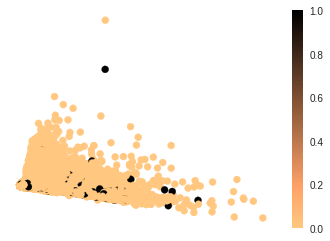

In [27]:
plt.scatter(x_scaler_pca_df.loc[:, 0], x_scaler_pca_df.loc[:, 1], c=y,  cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [29]:
scaler_x_train, scaler_x_test, scaler_y_train, scaler_y_test = train_test_split(x_scaler, y, test_size=0.3)

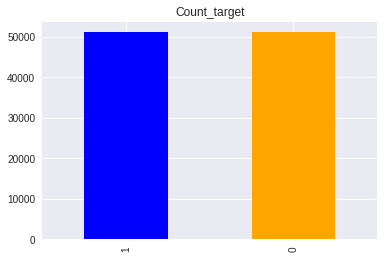

In [31]:
smote = SMOTE()
x_over, y_over = smote.fit_resample(scaler_x_train,scaler_y_train)
y_over = pd.Series(y_over)
y_over.value_counts().plot(kind='bar',title='Count_target',color=['blue','orange'])

In [33]:
type(y_over)

pandas.core.series.Series

## Modeling


*   LogisticRegression
*   LightGBM Classification



In [37]:
def get_clf_eval(y_test, pred=None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('confusion')
    print(confusion)
    print('Accuracy:{}'.format(np.around(accuracy, 4)))
    print('Precision:{}'.format(np.around(precision, 4)))
    print('Recall:{}'.format(np.around(f1, 4)))
    print('ROC_AUC:{}'.format(np.around(roc_auc, 4)))

* LogisticRegression




In [38]:
lg_reg = LogisticRegression()
lg_reg.fit(x_over, y_over)
pred = lg_reg.predict(scaler_x_test)
pred_proba = lg_reg.predict_proba(scaler_x_test)[:, 1]
get_clf_eval(scaler_y_test, pred, pred_proba)

confusion
[[15263  6634]
 [  232   677]]
Accuracy:0.6989
Precision:0.0926
Recall:0.1647
ROC_AUC:0.795


In [39]:
# imbalance_data 그대로 사용 할 경우
lg_reg1 = LogisticRegression()
lg_reg1.fit(scaler_x_train,scaler_y_train)
pred = lg_reg1.predict(scaler_x_test)
pred_proba = lg_reg1.predict_proba(scaler_x_test)[:, 1]
get_clf_eval(scaler_y_test, pred, pred_proba)

confusion
[[21879    18]
 [  904     5]]
Accuracy:0.9596
Precision:0.2174
Recall:0.0107
ROC_AUC:0.7961


* LightGBM Classifier

In [40]:
scaler_x_test, scaler_x_val, scaler_y_test, scaler_y_val = train_test_split(scaler_x_test, scaler_y_test, test_size=0.5)

In [41]:
train_data = lgb.Dataset(x_over, label=y_over)
val_data = lgb.Dataset(scaler_x_val, label=scaler_y_val)
params = {
    'n_estimators': 5000,
    'num_leaves': 20,
    'max_depth': -1,
    'min_data_in_leaf': 80,
    'learning_rate': 0.001,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'n_jobs': -1
}

In [43]:
model = lgb.train(params,
                  train_data,
                  valid_sets=val_data, 
                  valid_names=['train','valid'],
                  early_stopping_rounds=300)

[1]	train's auc: 0.806302
Training until validation scores don't improve for 300 rounds.
[2]	train's auc: 0.806302
[3]	train's auc: 0.806302
[4]	train's auc: 0.806302
[5]	train's auc: 0.806302
[6]	train's auc: 0.806302
[7]	train's auc: 0.806302
[8]	train's auc: 0.807221
[9]	train's auc: 0.807424
[10]	train's auc: 0.807776
[11]	train's auc: 0.807746
[12]	train's auc: 0.80755
[13]	train's auc: 0.80734
[14]	train's auc: 0.80734
[15]	train's auc: 0.80737
[16]	train's auc: 0.807474
[17]	train's auc: 0.807404
[18]	train's auc: 0.807404
[19]	train's auc: 0.80725
[20]	train's auc: 0.80725
[21]	train's auc: 0.80725
[22]	train's auc: 0.80725
[23]	train's auc: 0.807396
[24]	train's auc: 0.807396
[25]	train's auc: 0.807396
[26]	train's auc: 0.807396
[27]	train's auc: 0.807139
[28]	train's auc: 0.807022
[29]	train's auc: 0.807022
[30]	train's auc: 0.807022
[31]	train's auc: 0.807076
[32]	train's auc: 0.809024
[33]	train's auc: 0.809097
[34]	train's auc: 0.808964
[35]	train's auc: 0.808993
[36]	trai

In [44]:
!ls

sample_data	       test.csv      train.csv
sample_submission.csv  test.csv.zip  train.csv.zip


In [45]:
submission = pd.read_csv('sample_submission.csv')
submission.head()

,ID,TARGET
0,2,0
1,5,0
2,6,0
3,7,0
4,9,0


In [46]:
target = model.predict(test_df_scler)

In [47]:
target

array([0.51089414, 0.51163429, 0.39421515, ..., 0.40190853, 0.51089414,
       0.39421515])

In [48]:
submission['TARGET'] = target

In [49]:
submission.to_csv('first_submission.csv', index=False)